# Transfer Learning for Classification

Transfer learning leverages pre-trained models to achieve better performance with less data and training time.

In transfer learning:
- We start with a model pre-trained on a large dataset
- We repurpose it for a new, related task
- We may freeze early layers (feature extractors) and retrain only later layers

Benefits:
- Requires less training data
- Faster convergence
- Often better performance

### Example: Transfer Learning with Pre-trained CNN

transfer learning demo using a pre-trained MobileNetV2 model:

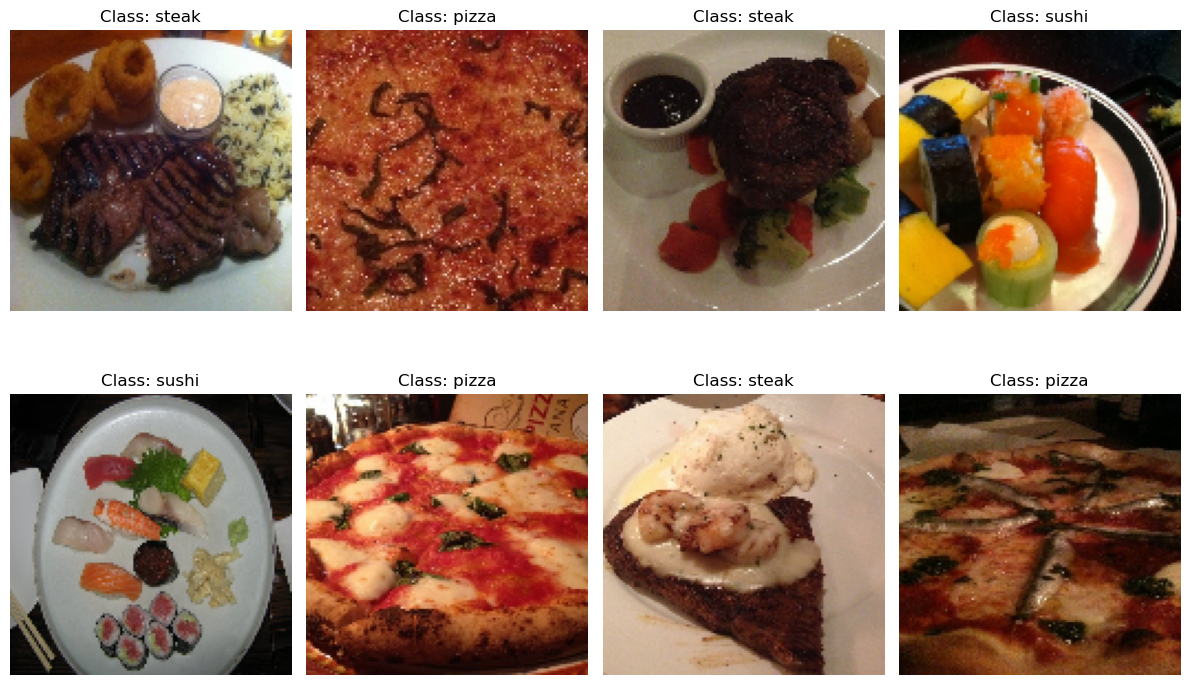

In [15]:
# Import necessary components for transfer learning
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from utils.utils import load_images_from_folder
import matplotlib.pyplot as plt

# Define paths
base_dir = "data/pizza_steak_sushi"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Image dimensions - adjust as needed for your model
img_height = 128
img_width = 128

X_train_img, y_train_labels = load_images_from_folder(train_dir, (img_height, img_width), classes_to_use=['all'])
X_test_img, y_test_labels = load_images_from_folder(test_dir, (img_height, img_width), classes_to_use=['all'])

# Convert string labels to numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels)
y_test_encoded = label_encoder.transform(y_test_labels)

# Display some example images
plt.figure(figsize=(12, 8))
indices = np.random.choice(len(y_train_encoded), 8, replace=False)
for i, idx in enumerate(indices):
    plt.subplot(2, 4, i + 1)
    img = X_train_img[idx].copy()
    img = img / 256  # Approximate reverse of preprocessing
    plt.imshow(img)
    plt.title(f"Class: {label_encoder.classes_[y_train_encoded[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10


/Users/phillipsm/anaconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.3493 - loss: 1.7657 - val_accuracy: 0.0889 - val_loss: 1.9098
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5039 - loss: 1.0276 - val_accuracy: 0.0889 - val_loss: 2.2048
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7224 - loss: 0.6667 - val_accuracy: 0.1556 - val_loss: 2.0467
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8300 - loss: 0.4902 - val_accuracy: 0.2889 - val_loss: 1.7747
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9337 - loss: 0.2979 - val_accuracy: 0.3778 - val_loss: 1.4834
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9642 - loss: 0.2197 - val_accuracy: 0.4889 - val_loss: 1.2442
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9691 - loss: 0.1627 - val_accuracy: 0.5778 - val_loss: 1.1113
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9882 - loss: 0.1214 - val_accuracy: 0.6222 - val_loss: 1.0405
Epoch 9/10

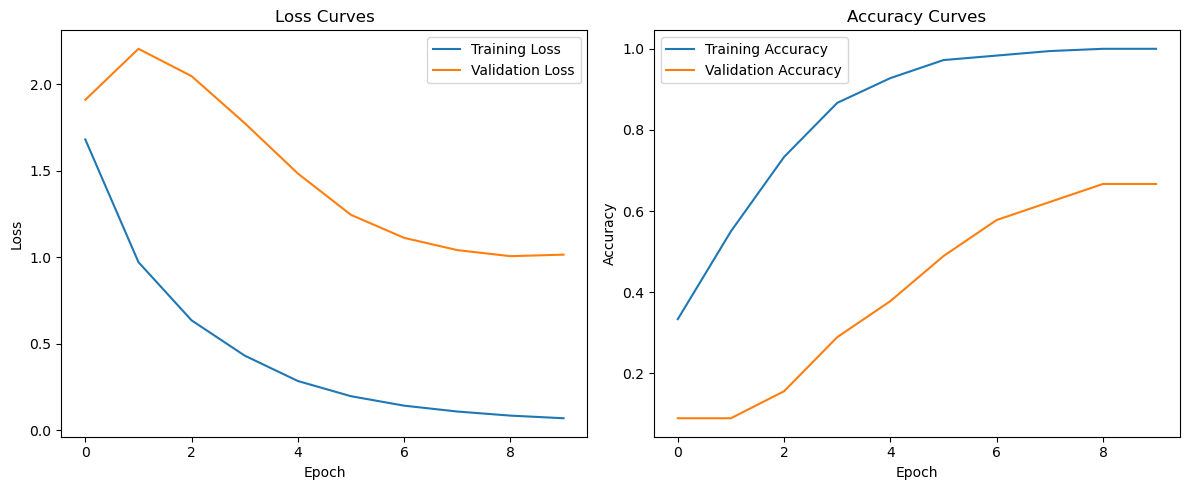

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
Transfer Learning Accuracy: 0.8133333333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87        25
           1       0.63      0.89      0.74        19
           2       0.89      0.77      0.83        31

    accuracy                           0.81        75
   macro avg       0.82      0.82      0.81        75
weighted avg       0.84      0.81      0.82        75



In [17]:

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the transfer learning model
def create_transfer_learning_model(base_model, input_shape):
    model = Sequential([
        # Preprocessing layer
        keras.layers.Lambda(lambda x: preprocess_input(x), input_shape=input_shape),
        
        # Pre-trained base model (feature extractor)
        base_model,
        
        # New classification layers
        Flatten(),
        Dense(128, activation='relu'),
        # Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train the transfer learning model
transfer_model = create_transfer_learning_model(base_model, (img_height, img_width, 3))
history = transfer_model.fit(
    X_train_img, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot the learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the transfer learning model
y_pred_proba = transfer_model.predict(X_test_img)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Transfer Learning Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))

### Fine-tuning: Unfreezing Layers

Now, let's demonstrate how to fine-tune our transfer learning model by unfreezing some of the "top" layers:

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9509 - loss: 0.2037 - val_accuracy: 0.6667 - val_loss: 0.9207
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9882 - loss: 0.0910 - val_accuracy: 0.7111 - val_loss: 0.8627
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0516 - val_accuracy: 0.7111 - val_loss: 0.9221
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0548 - val_accuracy: 0.7333 - val_loss: 0.8726
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0194 - val_accuracy: 0.7111 - val_loss: 0.8668
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.7111 - val_loss: 0.8635
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.7333 - val_loss: 0.8828
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.7333 - val_loss: 0.8831

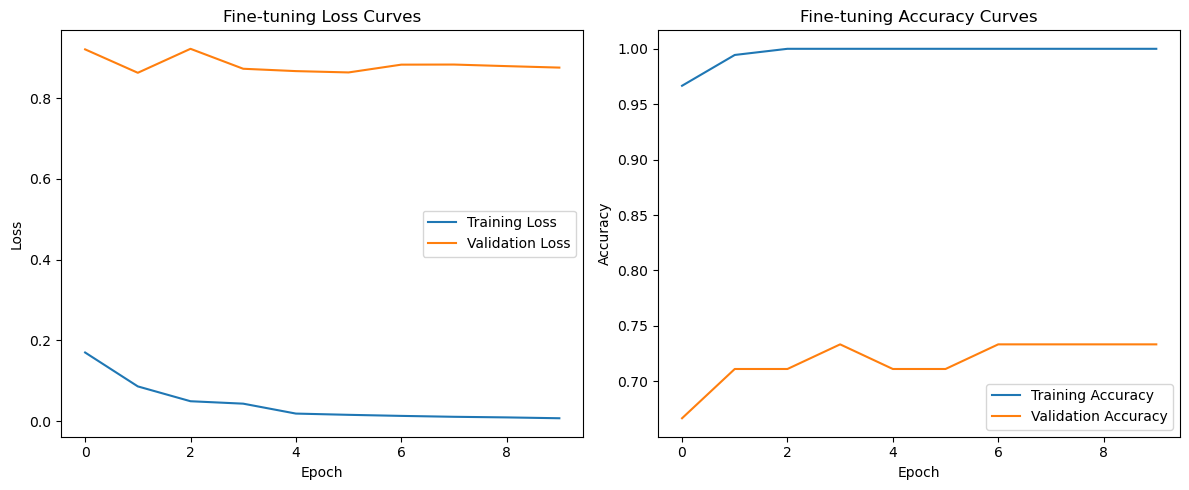

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
Fine-tuned Model Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        25
           1       0.70      1.00      0.83        19
           2       0.96      0.81      0.88        31

    accuracy                           0.88        75
   macro avg       0.89      0.90      0.88        75
weighted avg       0.91      0.88      0.88        75



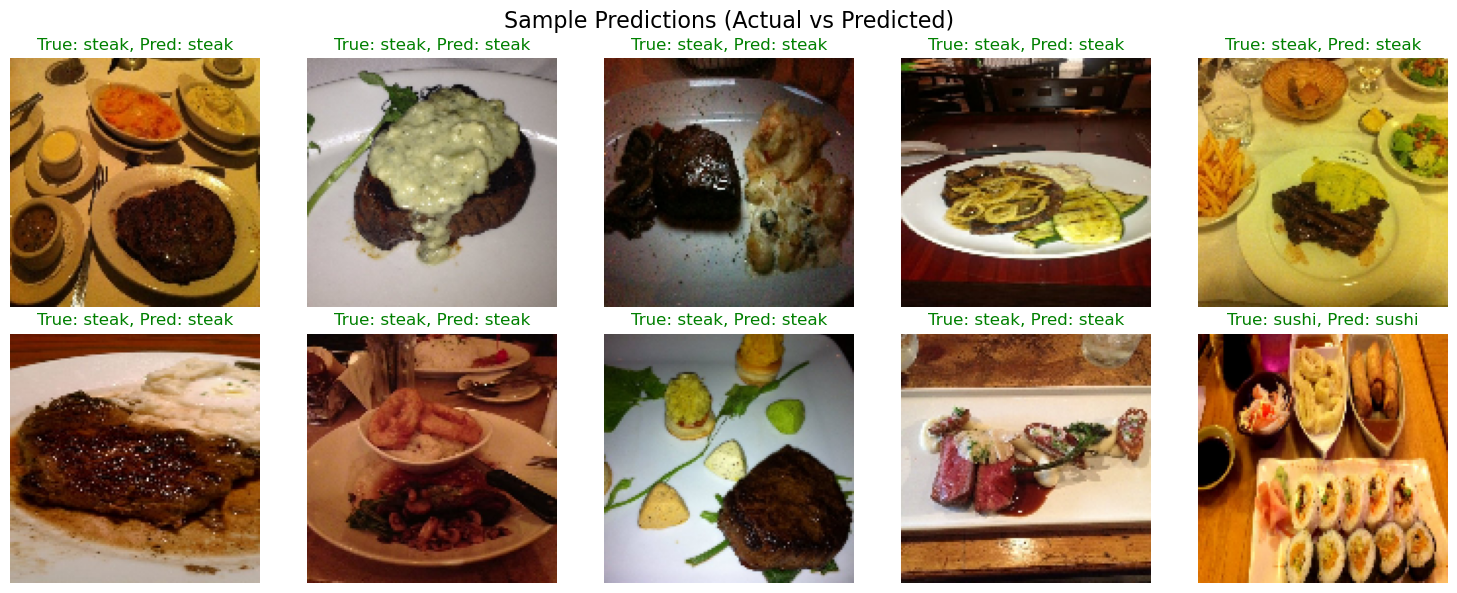

In [18]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-3:]:  # Unfreeze the last 3 layers (one conv block)
    layer.trainable = True

# Recompile the model with a lower learning rate
transfer_model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_finetune = transfer_model.fit(
    X_train_img, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot the fine-tuning learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Fine-tuning Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuning Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the fine-tuned model
y_pred_proba = transfer_model.predict(X_test_img)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Fine-tuned Model Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))

# Visualize some predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Predictions (Actual vs Predicted)', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    idx = i + 10  # Skip the first few for variety
    ax.imshow(X_test_img[idx].reshape(img_height, img_width, 3) / 256)
    pred_class = int(y_pred[idx])
    true_class = int(y_test_encoded[idx])
    
    color = 'green' if pred_class == true_class else 'red'
    ax.set_title(f"True: {label_encoder.classes_[true_class]}, Pred: {label_encoder.classes_[pred_class]}", color=color)
    ax.axis('off')

# set first axis to logy
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Key Concepts in Transfer Learning

1. **Pre-trained Models**:
   - Models trained on large datasets (e.g., ImageNet)
   - Extract general features from images
   - Examples: VGG, ResNet, MobileNet, EfficientNet

2. **Feature Extraction**:
   - Use pre-trained model as a fixed feature extractor
   - Only train new classification layers on top

3. **Fine-tuning**:
   - After initial training, unfreeze some layers
   - Continue training with a lower learning rate
   - Adapt the pre-trained features to the specific task

4. **Advantages for Planetary Science**:
   - Particularly useful for limited datasets
   - Can leverage patterns learned from Earth-based images (where we have ground truth)
   - Speeds up model development for specific applications